In [1]:
import numpy as np
import datajoint as dj
import matplotlib.pyplot as plt
import pandas as pd
import os
import utilities
from utilities.getStim import *

plt.style.use('dark_background')
pd.set_option('display.max_columns', None)

In [ ]:
saving_path = "Data/"
plot_all = False #False if you don't want to see all cells
save = False # if you want to save the data

In [3]:
dj.conn(host='vfsmdatajoint01.fsm.northwestern.edu', user='Santiago')
dj.config['stores'] = {
    'raw': {
        'protocol':'file',
        'location':r'\\fsmresfiles.fsm.northwestern.edu\fsmresfiles\Ophthalmology\Research\SchwartzLab\Datajoint\raw',
    }
}
symphony = dj.create_virtual_module(module_name='symphony', schema_name='sln_symphony')
cells = dj.create_virtual_module(module_name='cells', schema_name='sln_cell')

def AssignCellType():
    
    current = cells.Cell * cells.CellEvent * cells.AssignType & \
    cells.Cell.aggr(cells.AssignType * cells.CellEvent, entry_time = "max(entry_time)") * dj.U('entry_time')

    current = current.proj('cell_type','cell_class','source_id')

    return current

[2025-06-09 17:02:40,703][INFO]: Connecting Santiago@vfsmdatajoint01.fsm.northwestern.edu:3306
[2025-06-09 17:02:41,279][INFO]: Connected Santiago@vfsmdatajoint01.fsm.northwestern.edu:3306


In [4]:
cell_key = symphony.Experiment.Cell().proj(
    cell_name='concat(file_name, "c", cell_number)'
)

pn_celltype = (
      symphony.Experiment.ProtTemporalNoise1FV1ep()
    * symphony.Experiment.ProtTemporalNoise1FV1bp()
    * (symphony.SpikeTrain()
       * (symphony.Dataset.Epoch()            # links spike train to the stimulus epoch
          * cells.Cell                        # cell info
          * AssignCellType()                  # most‑recent assigned type
          * cell_key)                         # adds cell_name
       & 'channel_name="Amp1"')
    * symphony.Experiment.Channel()
    * symphony.Experiment.Epoch()
    * symphony.Experiment.ProjectorSettings()
)

pn_data = pn_celltype.fetch(format='frame').reset_index()


columns_to_drop = ['bit_depth', 'offset_x', 'offset_y', 'cell_class', 'event_id',
                   'color_noise_distribution', 'color_noise_mode', 'source_id', 'betas',
                   'epoch_group_id'	,'epoch_block_id',	'epoch_id', 'protocol_version', 
                   'seed_start_value',
                   'epoch_start_time', 'antialias', 'ndf']
pn_data = pn_data.drop(columns=columns_to_drop)
first_cols = ['animal_id', 'cell_unid', 'cell_type', 'cell_name']
first_cols = [col for col in first_cols if col in pn_data.columns]
other_cols = [col for col in pn_data.columns if col not in first_cols]

pn_data = pn_data[first_cols + other_cols]
pn_data['stimulus'] = pn_data.apply(lambda row: getStim_pink(row), axis=1)
pn_data['spike_times'] = pn_data.apply(convert_spike_indices_to_times, axis=1)


In [5]:
bin_size = 1.0 / pn_data['frame_rate'].iloc[0]  
total_duration = (pn_data['pre_time'].unique()[0] + pn_data['stim_time'].unique()[0] + pn_data['tail_time'].unique()[0])/1000
num_bins = int(np.round(total_duration / bin_size))
bin_edges = np.linspace(0, total_duration, num_bins + 1)

def bin_spike_times_list_of_lists(spike_times_list):
    flat_spikes = [spk for sublist in spike_times_list for spk in sublist]
    return np.histogram(flat_spikes, bins=bin_edges)[0]

pn_data['spike_train'] = pn_data['spike_times'].apply(bin_spike_times_list_of_lists)


In [6]:
# Compute firing rate
repeated_trials = pn_data[pn_data['noise_seed'] == 1].copy()
trial_counts = repeated_trials.groupby(['cell_name', 'beta']).size().reset_index(name='n_trials')
valid_pairs = trial_counts[trial_counts['n_trials'] > 2]
n_betas_total = trial_counts.groupby('cell_name')['beta'].nunique().reset_index(name='n_betas_total')
n_betas_valid = valid_pairs.groupby('cell_name')['beta'].nunique().reset_index(name='n_betas_valid')
stable_cells = pd.merge(n_betas_total, n_betas_valid, on='cell_name', how='left').fillna(0)
stable_cells = stable_cells[stable_cells['n_betas_total'] == stable_cells['n_betas_valid']]['cell_name']
repeated_trials = repeated_trials[repeated_trials['cell_name'].isin(stable_cells)]
repeated_trials['firing_rate'] = repeated_trials['spike_count'] / repeated_trials['epoch_duration']

# Group by cell and beta
rows = []

for (aid, cname, beta), group in repeated_trials.groupby(['animal_id', 'cell_name', 'beta']):
    firing_rates = group['firing_rate'].values
    if len(firing_rates) < 2:
        continue

    mean_fr = np.mean(firing_rates)
    min_fr = np.min(firing_rates)
    max_fr = np.max(firing_rates)

    min_ratio = min_fr / mean_fr if mean_fr > 0 else np.nan
    max_ratio = max_fr / mean_fr if mean_fr > 0 else np.nan

    is_stable = (min_ratio >= 0.5) and (max_ratio <= 1.5)

    rows.append({
        'animal_id': aid,
        'cell_name': cname,
        'beta': beta,
        'min_ratio': min_ratio,
        'max_ratio': max_ratio,
        'is_stable': is_stable
    })

# Create DataFrame
fr_df = pd.DataFrame(rows)

# Count beta conditions per cell
n_betas_per_cell = fr_df.groupby(['animal_id', 'cell_name'])['beta'].nunique().reset_index(name='n_betas')
n_stable_betas = fr_df[fr_df['is_stable']].groupby(['animal_id', 'cell_name'])['beta'].nunique().reset_index(name='n_stable_betas')

# Identify fully stable cells
stability = pd.merge(n_betas_per_cell, n_stable_betas, on=['animal_id', 'cell_name'], how='left').fillna(0)
fully_stable = stability[stability['n_betas'] == stability['n_stable_betas']][['animal_id', 'cell_name']]

# Add cell type
fully_stable = pd.merge(
    fully_stable,
    pn_data[['animal_id', 'cell_name', 'cell_type']].drop_duplicates(),
    on=['animal_id', 'cell_name'],
    how='left'
)

# Identify filtered-out cells
all_cells = pn_data[['animal_id', 'cell_name', 'cell_type']].drop_duplicates()
unstable_cells = pd.merge(
    all_cells,
    fully_stable,
    on=['animal_id', 'cell_name', 'cell_type'],
    how='outer',
    indicator=True
)
unstable_cells = unstable_cells[unstable_cells['_merge'] == 'left_only'].drop(columns=['_merge'])

# Keep all trials of stable cells
stable_df = pn_data.merge(fully_stable[['animal_id', 'cell_name']], on=['animal_id', 'cell_name'])

# Print summary
print(f"Total unique cells before filtering: {all_cells.shape[0]}")
print(f"Total unique cells after filtering: {fully_stable.shape[0]}")
print(f"Number of cells filtered out: {unstable_cells.shape[0]}")
print("\nFiltered-out cells:")
print(unstable_cells)


Total unique cells before filtering: 18
Total unique cells after filtering: 11
Number of cells filtered out: 7

Filtered-out cells:
    animal_id  cell_name                cell_type
0        3798  030525Ac8  OFF transient medium RF
1        3820  040325Bc1                 ON alpha
4        3820  040325Bc9      OFF sustained alpha
10       3839  032825Bc5                 ON alpha
12       3839  032825Bc7   ON transient medium RF
13       3875  030825Bc8      OFF transient alpha
14       3878  031125Bc1             unclassified


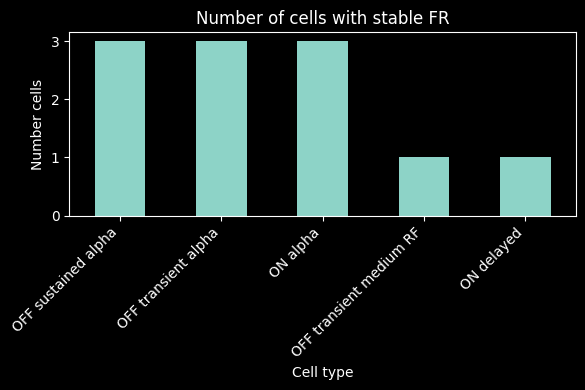

In [7]:
cell_counts = stable_df.groupby('cell_type')['cell_name'].nunique().sort_values(ascending=False)
plt.figure(figsize=(6, 4))
cell_counts.plot(kind='bar')
plt.ylabel('Number cells')
plt.xlabel('Cell type')
plt.xticks(rotation=45, ha='right')
plt.title('Number of cells with stable FR')
plt.tight_layout()

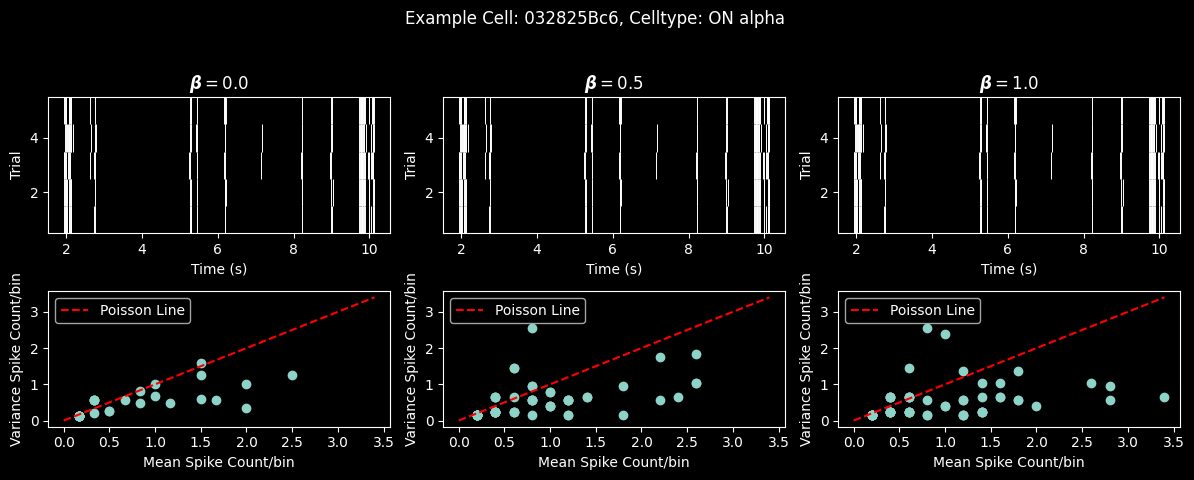

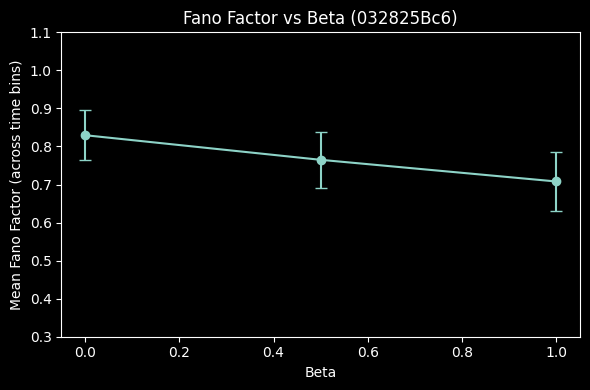

In [8]:
cell_name = '032825Bc6'
example_cell = pn_data[
    (pn_data['cell_name'] == cell_name) &
    (pn_data['noise_seed'] == 1)
]

num_beta_cell = example_cell['beta'].nunique()
if example_cell.shape[0] <= num_beta_cell:
    raise ValueError('This cell does not have repeated trials for each beta.')

sorted_betas = sorted(example_cell['beta'].unique())
fano_per_beta = {}

for i, beta in enumerate(sorted_betas):
    group = example_cell[example_cell['beta'] == beta]
    trials = np.stack(group['spike_train'].values)
    mean = np.mean(trials, axis=0)
    var = np.var(trials, axis=0)

    ##trial to trial variability
    mean_per_trial = np.mean(trials, axis=1)
    var_per_trial = np.var(trials, axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        fano = var / mean
    valid = ~np.isnan(fano)
    fano = fano[valid]

    with np.errstate(divide='ignore', invalid='ignore'):
        fano_per_trial = var_per_trial / mean_per_trial
    valid_trial = ~np.isnan(fano_per_trial)
    fano_per_trial = fano_per_trial[valid_trial]


    fano_per_beta[beta] = {
        'mean_trace': mean[valid],
        'var_trace': var[valid],
        'mean_trial': mean_per_trial[valid_trial],
        'var_trial': var_per_trial[valid_trial],
        'fano_trial': fano_per_trial,
        'fano_trace': fano
    }


fig, axes = plt.subplots(2, num_beta_cell, figsize=(4 * num_beta_cell, 5), squeeze=False)
fig.suptitle(f"Example Cell: {example_cell['cell_name'].iloc[0]}, Celltype: {example_cell['cell_type'].iloc[0]}")
for i, beta in enumerate(sorted_betas):
    # --- Raster Plot (Top Row)
    ax_raster = axes[0, i]
    bin_width = 1 / example_cell['frame_rate'].iloc[0]  # seconds per bin
    for trial_idx, spike_row in enumerate(trials):
        spike_times = np.where(spike_row > 0)[0] * bin_width  # non-zero bins
        for t in spike_times:
            ax_raster.vlines(t, trial_idx + 0.5, trial_idx + 1.5, color='w', linewidth=0.7)

    ax_raster.set_title(fr"$\boldsymbol{{\beta}}={beta}$")
    ax_raster.set_ylabel("Trial")
    ax_raster.set_xlabel("Time (s)")
    ax_raster.set_ylim(0.5, trials.shape[0] + 0.5)

    # --- Fano Scatter (Bottom Row)
    ax_fano = axes[1, i]
    ax_fano.scatter(fano_per_beta[beta]['mean_trace'], fano_per_beta[beta]['var_trace'])
    ax_fano.plot([0, max(mean)], [0, max(mean)], 'r--', label='Poisson Line')
    # ax_fano.set_title(f'Fano: beta={beta}')
    ax_fano.set_xlabel('Mean Spike Count/bin')
    ax_fano.set_ylabel('Variance Spike Count/bin')
    ax_fano.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

summary_data = {
    'beta': [],
    'mean_fano': [],
    'sem_fano': []
}

for i,beta in enumerate(sorted_betas):
    fano = fano_per_beta[beta]['fano_trace']
    summary_data['beta'].append(beta)
    summary_data['mean_fano'].append(fano.mean())
    summary_data['sem_fano'].append(np.std(fano) / np.sqrt(len(fano)))

summary_df = pd.DataFrame(summary_data).sort_values(by='beta')


fig_stats, axes_stats = plt.subplots(figsize=(6,4))
axes_stats.errorbar(summary_df['beta'], summary_df['mean_fano'], yerr=summary_df['sem_fano'],
            fmt='o-', capsize=4, label=example_cell['cell_name'].iloc[0])
axes_stats.set_ylim(0.3, 1.1)
axes_stats.set_xlabel("Beta")
axes_stats.set_ylabel("Mean Fano Factor (across time bins)")
axes_stats.set_title(f"Fano Factor vs Beta ({cell_name})")

axes
plt.tight_layout()
plt.show()

In [ ]:

if plot_all:
    for cell_name in stable_df['cell_name'].unique():
        example_cell = pn_data[
            (pn_data['cell_name'] == cell_name) &
            (pn_data['noise_seed'] == 1)
        ]

        num_beta_cell = example_cell['beta'].nunique()
        if example_cell.shape[0] <= num_beta_cell:
            raise ValueError('This cell does not have repeated trials for each beta.')

        sorted_betas = sorted(example_cell['beta'].unique())
        fano_per_beta = {}

        # Compute stats per beta
        for beta in sorted_betas:
            group = example_cell[example_cell['beta'] == beta]
            trials = np.stack(group['spike_train'].values)
            
            # Mean/Var across time bins (per bin)
            mean = np.mean(trials, axis=0)
            var = np.var(trials, axis=0)

            # Per-trial summary
            mean_per_trial = np.mean(trials, axis=1)
            var_per_trial = np.var(trials, axis=1)

            # Fano (bin-wise and trial-wise)
            with np.errstate(divide='ignore', invalid='ignore'):
                fano_trace = var / mean
                fano_trace = fano_trace[~np.isnan(fano_trace)]
                
                fano_trial = var_per_trial / mean_per_trial
                valid_trial = ~np.isnan(fano_trial)
                fano_trial = fano_trial[valid_trial]
                mean_per_trial = mean_per_trial[valid_trial]

            fano_per_beta[beta] = {
                'mean_trace': mean,
                'var_trace': var,
                'mean_trial': mean_per_trial,
                'var_trial': var_per_trial[valid_trial],
                'fano_trace': fano_trace,
                'fano_trial': fano_trial
            }

        # Plot raster + scatter
        fig, axes = plt.subplots(2, num_beta_cell, figsize=(4 * num_beta_cell, 5), squeeze=False)
        fig.suptitle(f"Example Cell: {example_cell['cell_name'].iloc[0]}, Celltype: {example_cell['cell_type'].iloc[0]}")

        for i, beta in enumerate(sorted_betas):
            group = example_cell[example_cell['beta'] == beta]
            trials = np.stack(group['spike_train'].values)

            # Raster plot
            ax_raster = axes[0, i]
            bin_width = 1 / example_cell['frame_rate'].iloc[0]
            for trial_idx, spike_row in enumerate(trials):
                spike_times = np.where(spike_row > 0)[0] * bin_width
                for t in spike_times:
                    ax_raster.vlines(t, trial_idx + 0.5, trial_idx + 1.5, color='w', linewidth=0.7)
            ax_raster.set_title(fr"$\boldsymbol{{\beta}}={beta}$")
            ax_raster.set_ylabel("Trial")
            ax_raster.set_xlabel("Time (s)")
            ax_raster.set_ylim(0.5, trials.shape[0] + 0.5)

            # Scatter of variance vs mean
            ax_fano = axes[1, i]
            ax_fano.scatter(fano_per_beta[beta]['mean_trace'], fano_per_beta[beta]['var_trace'], alpha=0.7)
            max_val = max(fano_per_beta[beta]['mean_trace'].max(), fano_per_beta[beta]['var_trace'].max())
            ax_fano.plot([0, max_val], [0, max_val], 'r--', label='Poisson Line')
            ax_fano.set_xlabel('Mean Spike Count/bin')
            ax_fano.set_ylabel('Variance Spike Count/bin')
            ax_fano.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        # --- Summary statistics bar plots ---
        summary_data = {
            'beta': [],
            'mean_fano_trace': [],
            'sem_fano_trace': [],
            'mean_fano_trial': [],
            'sem_fano_trial': [],
            'mean_rate': [],
            'sem_rate': []
        }

        for beta in sorted_betas:
            fano = fano_per_beta[beta]['fano_trace']
            fano_trial = fano_per_beta[beta]['fano_trial']
            mean_trial = fano_per_beta[beta]['mean_trial']

            summary_data['beta'].append(beta)
            summary_data['mean_fano_trace'].append(np.mean(fano))
            summary_data['sem_fano_trace'].append(np.std(fano) / np.sqrt(len(fano)))
            summary_data['mean_fano_trial'].append(np.mean(fano_trial))
            summary_data['sem_fano_trial'].append(np.std(fano_trial) / np.sqrt(len(fano_trial)))
            summary_data['mean_rate'].append(np.mean(mean_trial))
            summary_data['sem_rate'].append(np.std(mean_trial) / np.sqrt(len(mean_trial)))

        summary_df = pd.DataFrame(summary_data)

        # Plot summary
        fig_stats, axes_stats = plt.subplots(1, 2, figsize=(10, 4))

        # Fano per trial
        axes_stats[0].errorbar(summary_df['beta'], summary_df['mean_fano_trace'], yerr=summary_df['sem_fano_trace'], fmt='o-',
                        capsize=5)
        axes_stats[0].set_title("Fano Factor (across time) vs Beta")
        axes_stats[0].set_xlabel("Beta")
        axes_stats[0].set_ylabel("Fano Factor")
        axes_stats[0].set_ylim(0,1.1)

        # Mean spike rate
        axes_stats[1].bar(summary_df['beta'], summary_df['mean_rate'], yerr=summary_df['sem_rate'],
                        capsize=5, color='steelblue', edgecolor='w',
                        error_kw={'ecolor': 'white', 'elinewidth': 1.5})
        axes_stats[1].set_title("Mean Spike Rate (per trial) vs Beta")
        axes_stats[1].set_xlabel("Beta")
        axes_stats[1].set_ylabel("Spikes / Bin")
        axes_stats[1].set_ylim(0, max(summary_df['mean_rate'] + summary_df['sem_rate']) * 1.2)

        plt.tight_layout()
        plt.show()


In [10]:
columns_to_drop = ['cell_unid', 'file_name', 'channel_name', 'dataset_name', 'frame_dwell', 
                   'seed_change_mode', 'epoch_duration', 'spike_indices']
df_for_export = stable_df.drop(columns=columns_to_drop)
df_for_export = df_for_export.query('rstar_mean != 5784.8').reset_index(drop=True)
def adjust_trial_for_pre_time(row):
    pre_time_sec = row['pre_time'] / 1000.0
    stim_time_sec = row['stim_time'] / 1000.0
    tail_time_sec = row['tail_time'] / 1000.0
    frame_rate = row['frame_rate']

    pre_bins = int(pre_time_sec * frame_rate)
    stim_bins = int(stim_time_sec * frame_rate)

    # Flatten spike_times if needed
    spike_times = row['spike_times']
    if isinstance(spike_times, list) and any(isinstance(st, (list, np.ndarray)) for st in spike_times):
        spike_times = np.concatenate(spike_times)
    
    # Adjust spike times to stimulus-only window
    new_spike_times = [t - pre_time_sec for t in spike_times if pre_time_sec <= t < pre_time_sec + stim_time_sec]

    # Adjust spike_train and stimulus
    new_spike_train = row['spike_train'][pre_bins:pre_bins + stim_bins]

    stim = row['stimulus']
    if isinstance(stim, list):
        stim = np.array(stim)
    new_stimulus = stim[pre_bins:pre_bins + stim_bins]

    return pd.Series({
        'spike_times': new_spike_times,
        'spike_train': new_spike_train,
        'stimulus': new_stimulus
    })

adjusted = df_for_export.apply(adjust_trial_for_pre_time, axis=1)
for col in ['spike_times', 'spike_train', 'stimulus']:
    df_for_export[col] = adjusted[col]


In [ ]:
if save:
    df_for_export.to_hdf(os.path.join(saving_path, 'TemporalNoise1f_v2.h5'), key='data', mode='w')

C:\Users\SchwartzLab\AppData\Local\Temp\ipykernel_11248\3538241875.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['cell_type', 'cell_name', 'stimulus', 'spike_times', 'spike_train'], dtype='object')]

  df_for_export.to_hdf(os.path.join(saving_path, 'TemporalNoise1f_v2.h5'), key='data', mode='w')


STA window samples: 15
Total spikes used: 326


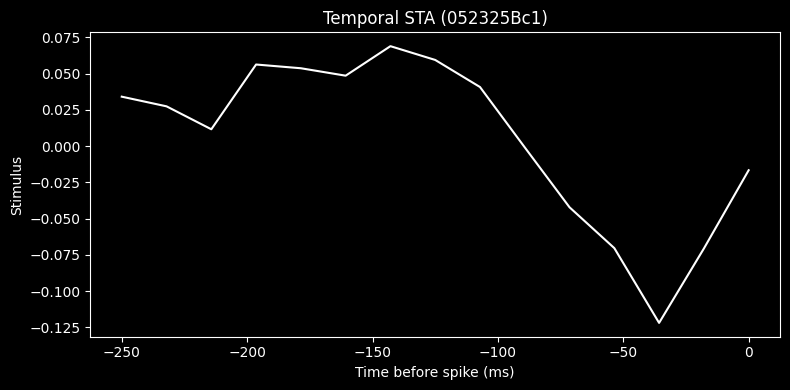

In [12]:
def STA_from_spike_times(row, window_size_ms=250, plotFlag=True):
    stimulus = np.array(row['stimulus'])
    spike_times = np.array(row['spike_times'])
    frame_rate = row['frame_rate']
    
    # Convert STA window from ms to number of frames
    sta_window_samples = int((window_size_ms / 1000) * frame_rate)
    print(f"STA window samples: {sta_window_samples}")

    # Convert spike times (in sec) to stimulus frame indices
    spike_indices = (spike_times * frame_rate).astype(int)

    # Filter spike_indices that are valid for STA window
    valid_spike_indices = spike_indices[spike_indices >= sta_window_samples]
    valid_spike_indices = valid_spike_indices[valid_spike_indices < len(stimulus)]

    # Accumulate stimulus windows
    sta_accumulator = np.zeros(sta_window_samples)
    total_spikes = 0
    for idx in valid_spike_indices:
        window = stimulus[idx - sta_window_samples:idx]
        if len(window) == sta_window_samples:
            sta_accumulator += window
            total_spikes += 1

    print("Total spikes used:", total_spikes)

    if total_spikes > 0:
        sta = sta_accumulator / total_spikes
        if plotFlag:
            time_axis = np.linspace(-window_size_ms, 0, sta_window_samples)
            plt.figure(figsize=(8, 4))
            plt.plot(time_axis, sta, label='STA', color='w')
            plt.xlabel('Time before spike (ms)')
            plt.ylabel('Stimulus')
            plt.title(f'Temporal STA ({row.cell_name})')
            plt.tight_layout()
            plt.show()
        return sta
    else:
        print("No valid spikes for STA.")
        return None
sta = STA_from_spike_times(stable_df.iloc[519], window_size_ms=250)
